# Shapley value of features

Shapley value is a game theory tool allowing one to determine how much an agent contributes to a payoff game. It can be applied in machine learning to interpret each feature importance.

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data gathering
df = pd.read_csv('feature_selection_result.csv', dtype=str)
df['Sensitivity'] = array(df['Sensitivity']).astype(float)
df['Specificity'] = array(df['Specificity']).astype(float)
df['MCC']         = array(df['MCC']).astype(float)
df['AUC']         = array(df['AUC']).astype(float)
df.head()

,Features,Sensitivity,Specificity,MCC,AUC
0,000000000000,0.453321,0.000000,0.000000,0.067767
1,000000000001,0.617647,0.587786,0.166876,0.289793
2,000000000010,0.554054,0.626374,0.180214,0.366895
3,000000000011,0.574468,0.704225,0.277120,0.464711
4,000000000100,0.623188,0.666667,0.287137,0.429324


In [3]:
# Lookup table to get feature action
# Example :
# lookups[SEN]['101000000000'] gives sensivity of random forest
# ran using only CADD1 and RecA.
#
# Features order: 
# CADD1,CADD2,RecA,EssA,CADD3,CADD4
# RecB,EssB,Distance,Path,Co-expression,AllelicState
#

SEN, SPE, MCC, AUC = range(4)
lookups = [{} for _ in range(4)]
for line in array(df):
    for i in range(4):
        lookups[i][line[0]] = line[i + 1]

In [4]:
# Factorial function
def fact(n):
    if n not in fact.memoize:
        fact.memoize[n] = fact(n - 1)*n
    return fact.memoize[n]
fact.memoize = {0: 1}

In [5]:
# binary(n) converts n into a binary string
# useful to enumerate feature combinations
def binary_rec(n):
    if n not in binary_rec.memoize:
        binary_rec.memoize[n] = binary_rec(n // 2) + str(n % 2)
    return binary_rec.memoize[n]
binary_rec.memoize = {0: '0', 1: '1'}

def binary(n):
    if n not in binary.memoize:        
        b = binary_rec(n)
        binary.memoize[n] = '0'*(11 - len(b)) + b
    return binary.memoize[n]
binary.memoize = {}

In [6]:
# Returns Shapley value for feature i given evaluation metrics 
# belonging to {SEN, SPE, MCC, AUC}
def get_shapley(values, feature_i, evaluation):
    
    def weight(st):
        return sum(int(ch) for ch in st)
    
    values = values[evaluation]
    
    return 1 / fact(12) * sum(
        fact(weight(s)) *
        fact(12 - weight(s) - 1) *
        (values[s[:feature_i] + '1' + s[feature_i+1:]] - values[s])
        for s in map(
            lambda s2: s2[:feature_i] + '0' + s2[feature_i:], 
            (binary(n) for n in range(2**11))
        )
    )

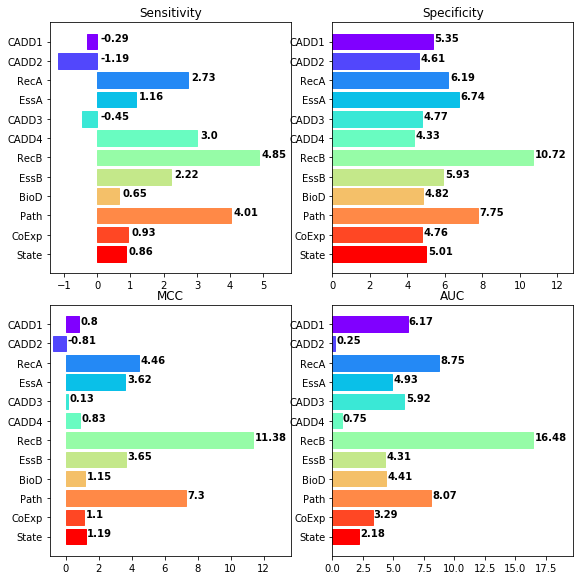

In [7]:
# Some plotting

fig, axes = subplots(nrows=2, ncols=2, figsize=(8, 8))
fig.tight_layout()

title('Shapley value')

labels = (
    'CADD1', 'CADD2', 'RecA', 'EssA',
    'CADD3', 'CADD4', 'RecB', 'EssB',
    'BioD', 'Path', 'CoExp', 'State'
)

titles = [
    'Sensitivity', 'Specificity', 'MCC', 'AUC'
]

colors = cm.rainbow(linspace(0, 1, len(labels)))

y_pos = arange(len(labels))
for i in range(4):
    ax = subplot(2, 2, i + 1)
    results = [get_shapley(lookups, j, i)*100 for j in range(len(labels))]
    
    m, M = min(0, min(results)*1.2), max(results)
    xlim( (m, M*1.2)  )
    bars = ax.barh(y_pos, results)
    
    for j, bar in enumerate(bars):
        bar.set_color(colors[j])
    
    for j, v in zip(y_pos, results):
        text(max(0.1, v + .1), j, str(round(v * 100)/100), color='black', fontweight='bold')
        
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
        
    title(titles[i])
    
savefig('shapley_plot.png')